## Up or down? Bimodal posteriors with the TRCRP mixture

This tutorial notebook helps build intuition for how the TRCRP mixture uses interplation from the history of the time series to generate forecasts. We demonstrate a test case where the history of the time series induces a bimodal predictive distribution in the forecasted data.

In [1]:
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
import numpy as np
import pandas as pd

In [3]:
rng = np.random.RandomState(564)

### Loading the dataset

In [4]:
frame = pd.read_csv('resources/up-or-down.csv')
frame.y = frame.y + rng.normal(0,.25, size=len(frame))

The plot below shows the univariate time series in question. The latest observations between 270 through 280 suggest the time series is increasing. We will forecast probably values of the time series over a 10-step horizon. Based on the previous observations where the time series values where rising, is there reason to believe that the time series will go up this time? Or will it go down?

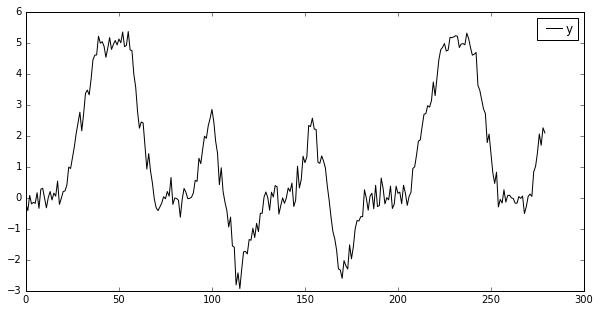

In [5]:
fig, ax = plt.subplots()
x_observed = frame.index
y_observed = frame['y'].values
ax.plot(x_observed, y_observed, label='y', color='k', linewidth=1)
ax.legend(loc='upper right', handletextpad=0)
ax.set_ylim([-3, 6])
fig.set_size_inches(10, 5)

### Building and learning a model

We build a TRCRP mixture with 8 chains and a lag of 10 timesteps, and run 500 steps of MCMC inference.

In [6]:
from trcrpm import TRCRP_Mixture
model = TRCRP_Mixture(chains=8, lag=10, variables=frame.columns, rng=rng)
model.incorporate(frame)

In [7]:
model.resample_all(steps=500)

Completed: 500 iterations in 16.222359 seconds.
Completed: 500 iterations in 16.618945 seconds.
Completed: 500 iterations in 17.334026 seconds.
Completed: 500 iterations in 18.490091 seconds.
Completed: 500 iterations in 21.838361 seconds.
Completed: 500 iterations in 23.202792 seconds.
Completed: 500 iterations in 23.617796 seconds.
Completed: 500 iterations in 24.562082 seconds.


In [8]:
model.resample_hyperparameters(steps=10)

Completed: 10 iterations in 1.289041 seconds.
Completed: 10 iterations in 2.608159 seconds.
Completed: 10 iterations in 3.170946 seconds.
Completed: 10 iterations in 3.176207 seconds.
Completed: 10 iterations in 3.373203 seconds.
Completed: 10 iterations in 3.416485 seconds.
Completed: 10 iterations in 3.869877 seconds.
Completed: 10 iterations in 3.877019 seconds.


### Generating forecasts

We now probe the time series to forecast `lag` steps into the future. Note we are using TRCRP_Mixture.[simulate_ancestral](https://probcomp-1.csail.mit.edu/trcrpm/doc/api.html#trcrpm.Hierarchical_TRCRP_Mixture.simulate_ancestral) instead of TRCRP_Mixture.[simulate](https://probcomp-1.csail.mit.edu/trcrpm/doc/api.html#trcrpm.Hierarchical_TRCRP_Mixture.simulate) to ensure that forecasts are generated from their joint distribution.

In [9]:
probes = range(max(model.dataset.index), max(model.dataset.index)+model.lag)
n_samples = 500

In [10]:
samples_ancestral = model.simulate_ancestral(probes, model.variables, n_samples)

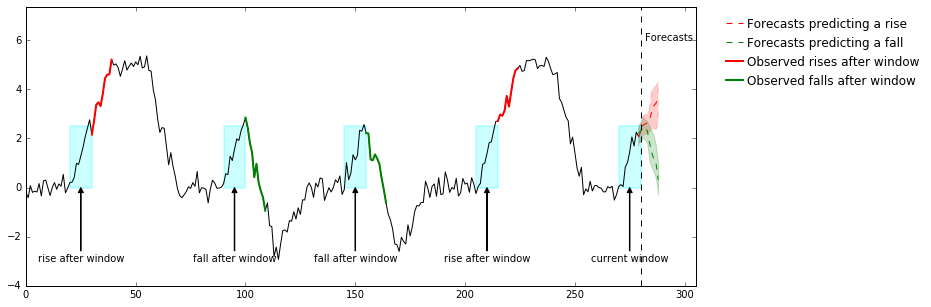

In [11]:
fig, ax = plt.subplots()

# Plot the observed data.
x_observed = model.dataset.index
y_observed = model.dataset.loc[:,'y'].values
ax.plot(x_observed, y_observed, color='k', linewidth=1)

xs = frame.index
ys = frame['y'].values

# Plot the simulations.
simulations = samples_ancestral[:,:,0]
above = simulations[simulations[:,-1]>simulations[:,0]]
below = simulations[simulations[:,-1]<simulations[:,0]]

ax.plot(probes, np.median(above, axis=0), color='r',
    linestyle='--', label = 'Forecasts predicting a rise')
ax.fill_between(probes,
    np.percentile(above, 25, axis=0),
    np.percentile(above, 75, axis=0),
    color='red',
    linestyle='--',
    alpha=0.2)

ax.plot(probes, np.median(below, axis=0), color='g',
    linestyle='--', label = 'Forecasts predicting a fall')
ax.fill_between(probes,
    np.percentile(below, 25, axis=0),
    np.percentile(below, 75, axis=0),
    color='g',
    alpha=0.2)

ax.set_ylim([min(y_observed)-2, max(y_observed)+2])
ax.set_xlim([min(model.dataset.index), max(probes)+20])

# Put boxes around the similar previous lags.
ax.add_patch(Rectangle((20,0), 10, 2.5, color='cyan', linewidth=2, alpha=0.2))
ax.add_patch(Rectangle((90,0), 10, 2.5, color='cyan', linewidth=2, alpha=0.2))
ax.add_patch(Rectangle((145,0), 10, 2.5, color='cyan', linewidth=2, alpha=0.2))
ax.add_patch(Rectangle((205,0), 10, 2.5, color='cyan', linewidth=2, alpha=0.2))
ax.add_patch(Rectangle((270,0), 10, 2.5, color='cyan', linewidth=2, alpha=0.2))

# Annotate the windows.
ax.annotate('rise after window', xy=(25, 0), xytext=(25, -3), horizontalalignment='center',
    arrowprops=dict(facecolor='black', width=0.5, headwidth=5, headlength=5))
ax.annotate('fall after window', xy=(95, 0), xytext=(95, -3), horizontalalignment='center',
    arrowprops=dict(facecolor='black', width=0.5, headwidth=5, headlength=5))
ax.annotate('fall after window', xy=(150, 0), xytext=(150, -3), horizontalalignment='center',
    arrowprops=dict(facecolor='black', width=0.5, headwidth=5, headlength=5))
ax.annotate('rise after window', xy=(210, 0), xytext=(210, -3), horizontalalignment='center',
    arrowprops=dict(facecolor='black', width=0.5, headwidth=5, headlength=5))
ax.annotate('current window', xy=(275, 0), xytext=(275, -3), horizontalalignment='center',
    arrowprops=dict(facecolor='black', width=0.5, headwidth=5, headlength=5))

# Color the post-window rise and post-window fall.
ax.plot(xs[30:40], ys[30:40], linewidth=2, color='r', label='Observed rises after window')
ax.plot(xs[100:110], ys[100:110], linewidth=2, color='g', label='Observed falls after window')
ax.plot(xs[155:165], ys[155:165], linewidth=2, color='g')
ax.plot(xs[215:225], ys[215:225], linewidth=2, color='r')

# Show the forecsating region and legend.
ax.axvline(280, linestyle='--', linewidth=1, color='k')
ax.text(282, 6, 'Forecasts', horizontalalignment='left')
ax.legend(loc='upper right', framealpha=0, handletextpad=0, bbox_to_anchor=(1.35,1))

ax.set_ylim([-4, None])
ax.set_xlim([0, 305])

fig.set_size_inches(12,5)

The model forecasts, shown after the dashed vertical line, contain two qualitative regimes. The green forecasts show samples where a fall is predicted, and the red forecasts show samples where a rise is predicted.

To understand how the model made these forecasts, we need to study the "current window" i.e. the values of the time series at the most recent `lag=10` timepoints (shown in cyan, at timestep 270). We also annotate in cyan four previous windows in the history of the time series which are probably "close" to the current window. Two of these windows (at timestep 20 and timestep 205) have a post-window rise, shown in red; the other two windows (at timesteps 90 and 145) have a post-window fall, shown in green. As an interpolator, the TRCRP mixture uses these previously observed patterns to generate forecasts. These two distinct qualitative regimes in the history are reflected by the bimodality in the forecasts.

To visualize the predictions, we produce histograms of the forecasted values at timesteps 279...288 from their marginal distributions. This query uses TRCRP_Mixture.[simulate](https://probcomp-1.csail.mit.edu/trcrpm/doc/api.html#trcrpm.Hierarchical_TRCRP_Mixture.simulate) to ensure that forecasts are generated by marginalizing uncertainty. The colored histograms of the predictions at each time step are shown below.

In [12]:
samples_marginal = model.simulate(probes, model.variables, n_samples)

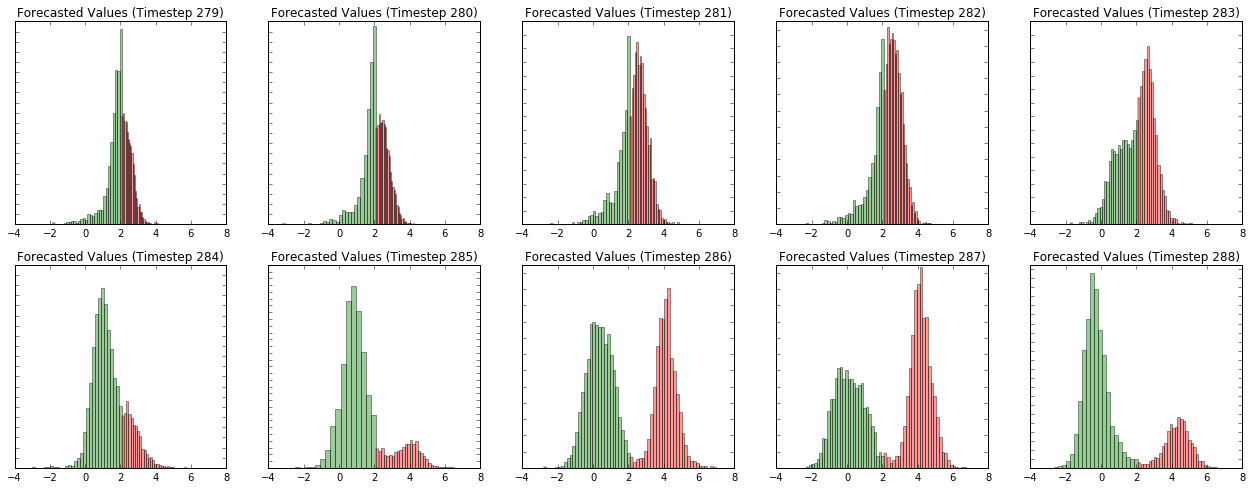

In [13]:
fig, axes = plt.subplots(nrows=model.lag/5, ncols=5)
last = model.dataset.iloc[-1].y
for lag, ax in enumerate(np.ravel(axes)):
    samples_lag = samples_marginal[:,lag,0]
    ax.hist(samples_lag[samples_lag<=last], bins=30, color='green', alpha=0.4)
    ax.hist(samples_lag[samples_lag>=last], bins=30, color='red', alpha=0.4)
    ax.set_xlim([-4,8])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.set_yticklabels([])
    ax.set_title('Forecasted Values (Timestep %03d)'
        % (model.dataset.index.max() + lag))
fig.set_size_inches(22,8)